## Predicting the Four and Five Year Graduation Rates for Public High Schools
**This notebook explores predicting the 4 and 5 year graduation rates for public high schools in North Carolina.** 
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/jakemdrew/EducationDataNC 
* The dataset used in this notebook is created prepared for machine learning in the notebook: NC EA Public High Schools Dataset Feb 2018
* The dataset name used in this notbook is: HighSchoolsML_02_2018.csv

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [19]:
#import required Libraries
import pandas as pd
import numpy as np

#Read in the high schools dataset - NC EA Public High Schools Dataset Feb 2018
url="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/Machine%20Learning%20Datasets/HighSchoolsML_02_2018.csv"
schData=pd.read_csv(url, low_memory=False)

#inspect data 
schData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Columns: 128 entries, title1_type_flg to 1_to_1_access_Yes
dtypes: bool(6), float64(102), int64(20)
memory usage: 422.0 KB


In [20]:
# create x explanatory and y response variables for regression
Y_4yr_Gr = schData['Graduation_Rate4_Yr']
Y_5yr_Gr = schData['Graduation_Rate_5_Yr']
X_highSchools = schData.drop(['Graduation_Rate4_Yr', 'Graduation_Rate_5_Yr','Cohort Graduation Rate Standard Score'], axis=1)

#inspect data 
X_highSchools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Columns: 125 entries, title1_type_flg to 1_to_1_access_Yes
dtypes: bool(6), float64(99), int64(20)
memory usage: 411.7 KB


In [17]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
#from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
#scaler = StandardScaler()
#scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
#X_highSchools = scaler.transform(X_highSchools)

## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [9]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

## Custom Scorers for Evaluating Regression Models 

**All regression models created in this notebook are validated using the following metrics:**
* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
* Mean Absolute Percentage Error (MAPE) - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python

**For details on making scorers to return multiple mean error scores see:**
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
* https://github.com/scikit-learn/scikit-learn/pull/7388
* https://github.com/drorata/multiscorer

In [4]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual <> 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               } 

## Regression Model Evaluation
** All regression models are evaluated using the regression model evaluation function below: ** 
* The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.
* The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.
* Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calcualted using a single call to cross_validate().
* All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train cv data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over. 

In [5]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults


## Four Year Graduation Rate - Baseline Regression Model

**Linear Regression is used to create a baseline model.  Since linear regression may predict response variable values outside the range of the training data's response variable, we create a linear regression estimator with graduation rate predictions clipped 0% and 100%. For details see:**
* http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator 
* https://github.com/scikit-learn/scikit-learn/issues/6950
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [21]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 100) 

### Linear Regression Grid Search
** Here we perform a grid search testing 40 models to find the best parameters for our Linear Regression model based on Mean Absolute Error.  See more on parameter tuning with grid search here:**
* http://scikit-learn.org/stable/modules/grid_search.html

In [22]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y_4yr_Gr)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=1,
            normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [23]:
#Print the parameterization of the best estimator
regGridSearch.best_estimator_

CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=1,
            normalize=False)

## Four Year Graduation Rate - Baseline Regression Model - Cross Validation
**Perform tenfold cross validation using the grid search "best" parameters and our Capped Linear Regression estimator**
* 10-fold cross-validation using the parameters for the top performing model 
* CAP predictions between 0 and 100% 
* Evaluate cross-validation results using MAE, MAPE, and RMSE

In [24]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y_4yr_Gr, cv)


The average MAE for all cv folds is: 			 4.7121
The average MAE percentage (MAPE) for all cv folds is: 	 5.3454
The average RMSE for all cv folds is: 			 6.5872
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,5.121766,5.873909,6.746030
1,4.402446,5.121599,5.591144
2,3.868971,4.503803,5.928800
3,4.732759,5.313276,6.148734
4,4.402592,5.166043,5.843780
5,5.534346,5.954754,9.699660
6,4.836650,5.333357,6.615646
7,5.165921,5.700414,7.324687
8,4.562238,5.372552,6.372281
9,4.493277,5.114502,5.600925


## Four Year Graduation Rate - Support Vector Regression
**This model uses Support Vector Machines for regression of continuous variables (SVR). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
* http://scikit-learn.org/stable/modules/svm.html

In [25]:
#Create a Linear regression object and perform a grid search to find the best parameters
from sklearn.svm import SVR
reg = SVR()

#Set up SVR parameters to test (WARNING: Creates 320 models!!!) 
costs = [0.001, 0.1, 1, 10]
defGamma = 1 / X_highSchools.shape[1]  #This is the default value for the gamma parameter
gammas = [defGamma, 0.1, 1, 10]
kernels = ['rbf','linear']
parameters = {'C': costs, 'gamma' : gammas, 'kernel': kernels}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y_4yr_Gr)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 38.3min
[Parallel(n_jobs=8)]: Done 320 out of 320 | elapsed: 118.1min finished


Fitting 10 folds for each of 32 candidates, totalling 320 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'kernel': ['rbf', 'linear'], 'C': [0.001, 0.1, 1, 10], 'gamma': [0, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [26]:
#Display the best estimator parameters
regGridSearch.best_estimator_

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [27]:
from sklearn.svm import SVR

#Create a regression estimator with best parameters for cross validation
regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                   kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y_4yr_Gr, cv)

The average MAE for all cv folds is: 			 4.2846
The average MAE percentage (MAPE) for all cv folds is: 	 4.8871
The average RMSE for all cv folds is: 			 5.6829
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,4.349173,5.038480,5.573910
1,3.674007,4.300935,4.820564
2,4.305151,5.050973,6.283658
3,4.432680,4.950796,5.694840
4,3.727194,4.497582,5.103303
5,4.741561,5.131206,6.677591
6,4.344726,4.825818,5.472019
7,4.096579,4.484854,5.140921
8,4.556290,5.387295,6.316892
9,4.618176,5.203395,5.745112


In [28]:
#Do we predict graduation rates greater than 100%?
regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                   kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

regEstimator.fit(X_highSchools, Y_4yr_Gr)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 106.57267779761087)


## Four Year Graduation Rate - Lasso Regression
**This model uses Lasso regression (L1 Norm). Please see documentation here:"**
* **Caution!** - See documentation for fit_intercept, normalize, and copy_X. Lasso can over-write your X data!
* Lasso may also perform scaling as well.  Please see docs!
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [29]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y_4yr_Gr)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    6.3s finished


Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'warm_start': [True, False], 'alpha': [0.001, 0.1, 1, 10, 20], 'selection': ['cyclic', 'random']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [30]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='random', tol=0.0001, warm_start=True)

In [31]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y_4yr_Gr, cv)

The average MAE for all cv folds is: 			 4.5946
The average MAE percentage (MAPE) for all cv folds is: 	 5.191
The average RMSE for all cv folds is: 			 6.1323
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,5.095004,5.852332,6.447985
1,4.157149,4.850637,5.385128
2,4.201592,4.781458,6.207312
3,4.605913,5.150027,6.057199
4,4.173818,4.883947,5.341644
5,5.222016,5.591831,8.102763
6,5.136795,5.623333,6.692995
7,4.807008,5.300629,6.125045
8,4.212507,4.962601,5.628721
9,4.333892,4.913469,5.334649


In [32]:
#Do we predict graduation rates greater than 100%?
regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=True)

regEstimator.fit(X_highSchools, Y_4yr_Gr)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 106.27057544379356)


## Four Year Graduation Rate - Ridge Regression
**This model uses Ridge regression (L2 Norm). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [33]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

reg = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y_4yr_Gr)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 245 tasks      | elapsed:   10.3s
[Parallel(n_jobs=8)]: Done 345 out of 360 | elapsed:   10.8s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:   10.9s finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='auto', tol=0.0001),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20], 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [34]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
   random_state=0, solver='lsqr', tol=0.0001)

In [35]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y_4yr_Gr, cv)

The average MAE for all cv folds is: 			 4.1795
The average MAE percentage (MAPE) for all cv folds is: 	 4.8024
The average RMSE for all cv folds is: 			 5.4396
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,4.720214,5.482667,5.849219
1,3.812085,4.528573,5.100726
2,4.008430,4.756746,5.771627
3,4.419724,4.964402,5.645659
4,4.075617,4.936627,5.631970
5,4.457132,4.868247,5.618462
6,4.380188,4.884266,5.410438
7,4.059850,4.447738,4.921177
8,3.836394,4.593793,5.383016
9,4.025527,4.561277,5.064007


In [36]:
#Do we predict graduation rates greater than 100%?
regEstimator = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='saga', tol=0.0001)

regEstimator.fit(X_highSchools, Y_4yr_Gr)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 105.659982310523)


## Four Year Graduation Rate - Elastic Net Regression
**This model uses Elastic Net Regression (L1 and L2 Norm mixing). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [37]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

reg = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y_4yr_Gr)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 542 tasks      | elapsed:    8.2s
[Parallel(n_jobs=8)]: Done 960 out of 960 | elapsed:    9.7s finished


Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'warm_start': [True, False], 'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1], 'selection': ['cyclic', 'random'], 'alpha': [0.001, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [38]:
#Display the best estimator parameters
regGridSearch.best_estimator_

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.001,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=True)

In [39]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y_4yr_Gr, cv)

The average MAE for all cv folds is: 			 4.1744
The average MAE percentage (MAPE) for all cv folds is: 	 4.7739
The average RMSE for all cv folds is: 			 5.4004
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,4.725931,5.482142,5.884360
1,3.789923,4.484405,5.014324
2,3.930951,4.583633,5.493130
3,4.435241,4.968779,5.752780
4,4.022021,4.813877,5.259884
5,4.389151,4.796386,5.694400
6,4.433552,4.935890,5.554505
7,4.294301,4.712322,5.186484
8,3.720801,4.421134,5.112600
9,4.002380,4.540015,5.051266


In [40]:
#Do we predict graduation rates greater than 100%?
regEstimator = ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.75,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=True)

regEstimator.fit(X_highSchools, Y_4yr_Gr)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 105.67981762603819)


## Four Year Graduation Rate - Logit Regression using GLM and R 
**This model uses GLM and R. Please see documentation here:"**
* **WARNING** - You must have the R Kernel installed to use this code!!!
* Logit Regression is performed on graduation rates scaled in the range 0 to 1
* The GLM package in R uses the parameter Family=binomial(link='logit') to perform this regression.
* It may be possible to use Rmagic and Rpy2 from within Python to accomplish the same tasks.  However, this is not yet supported on Windows.  The code below works on Mac or Windows.

**Testing and training fold data are first written out to disk as .csv files using Python.** 

In [41]:
#write our test / train folds out to disk so we may use them in R 
foldct = 1
dirPath = "D:/BenepactLLC/Belk/NC_Report_Card_Data/February 2018 Report/Datasets/"

for train, test in cv.split(schData):
    testFileName = dirPath + 'TestFold' + str(foldct) + '.csv'
    trainFileName = dirPath + 'TrainFold' + str(foldct) + '.csv'
    schData.iloc[test].to_csv(testFileName, sep=',', index=False)
    schData.iloc[train].to_csv(trainFileName, sep=',', index=False)
    foldct = foldct + 1

**Testing and training fold data are read in from .csv files using R.** 

In [1]:
#*********************************must switch to the R kernel to run this code!********************************* 


options(warn=-1)

setwd("D:/BenepactLLC/Belk/NC_Report_Card_Data/February 2018 Report/Datasets/")

#*************************************************************************************
#*********************************Evaluation Scores **********************************
#*************************************************************************************

#Use RMSE and MAE To evaluate performance
#See: https://heuristically.wordpress.com/2013/07/12/calculate-rmse-and-mae-in-r-and-sas/

# Function that returns Root Mean Squared Error
rmse <- function(error)
{
    sqrt(mean(error^2))
}
 
# Function that returns Mean Absolute Error
mae <- function(error)
{
    mean(abs(error))
}

#*************************************************************************************
#*********************************10 Fold CV******************************************
#*************************************************************************************
tenFoldResults<-NULL
drop <- c("Graduation_Rate_5_Yr")
y <- c("Graduation_Rate4_Yr")

#Perform 10 fold cross validation
for(i in 1:10){
    #Get file paths
    testFile <- paste(c("TestFold", i, ".csv"), collapse = "") 
    trainFile <- paste(c("TrainFold", i, ".csv"), collapse = "") 

    #Read in files for each fold 
    testData <- read.csv(testFile,header=T)
    trainData <- read.csv(trainFile,header=T)
    
    #Remove 5 year graduation rate
    testData <- testData[ , !(names(testData) %in% drop)]
    trainData <- trainData[ , !(names(trainData) %in% drop)]
    
    #Scale 4 year graduation rate 0 to 1 binomial(link='logit')
    testData[ , y] <- testData[ , y] / 100
    trainData[ , y] <- trainData[ , y] / 100
    
    #Train glm model 
    model <- glm(Graduation_Rate4_Yr ~.,family=binomial(link='logit'),data=trainData)
    yhat <- predict(model,newdata=testData[ , !(names(testData) %in% y)],type='response')

    #Get correct answers for predictions
    actual <- testData[ , y]
    
    #Convert y and yhat graduation rates back to normal percentage scale
    actual <- actual * 100 
    yhat <- yhat * 100 
    
    #Calcuate our errors
    error = actual - yhat
    
    #Capture results in a dataframe
    tenFoldResults <- rbind(tenFoldResults,
    data.frame(Package='GLM'
              ,FoldCount= length(yhat) 
              ,MAE=mae(error)
              ,RMSE=rmse(error)
              )
    )
}

paste(c("The max value predicted is:", max(yhat)), collapse = " ") 
paste(c("The average MAE for all cv folds is:", mean(tenFoldResults[,c('MAE')])), collapse = " ") 
paste(c("The average RMSE for all cv folds is:", mean(tenFoldResults[,c('RMSE')])), collapse = " ") 
tenFoldResults

#Turn R warnings back on 
options(warn=0)

[1] "The max value predicted is: 99.612766216484"

[1] "The average MAE for all cv folds is: 6.08551806296113"

[1] "The average RMSE for all cv folds is: 10.9171721504842"

,Package,FoldCount,MAE,RMSE
1,GLM,44,5.846933,8.996489
2,GLM,44,5.215274,6.841639
3,GLM,44,6.967699,15.144
4,GLM,44,5.264022,8.28872
5,GLM,44,6.598374,11.42233
6,GLM,44,6.570134,13.46127
7,GLM,44,5.402386,8.600417
8,GLM,44,7.338033,16.36494
9,GLM,44,5.738696,9.606818
10,GLM,44,5.913629,10.4451


## Four Year Graduation Rate - Logit Regression using Python 
**This model uses a custom Logit model based on transformations of the Linear Regression object. Please see documentation here:"**
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [42]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p[p==0] = 0.009    #0.1111111111111111 
        p[p==1] = 0.991    #0.9999999999999999  big precision seems to kill MAE scores here?
        #e = 0.0000000000000001
        #p = p * e + 0.5 * e                    This technique was really bad too. 
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super(LogitRegression, self).fit(x, y)

    def predict(self, x):
        y = super(LogitRegression, self).predict(x)
        yhat = 1 / (np.exp(-y) + 1)
        yhat[yhat <= 0.009] = 0
        yhat[yhat >= 0.991] = 1
        return yhat

In [43]:
#convert y to a proability 
Y_4yr_Gr_Pct = Y_4yr_Gr / 100

#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = LogitRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   #, n_jobs=8 # jobs to run in parallel (This breaks the custom estimators for some reason!)
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y_4yr_Gr_Pct)

C:\Users\Jake\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: overflow encountered in exp
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.6s finished


Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogitRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [44]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogitRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**Since we converted our response variable to a percentile MAE and RMSE results below must be mutiplied by 100.**

In [45]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y_4yr_Gr_Pct, cv)

The average MAE for all cv folds is: 			 0.058859
The average MAE percentage (MAPE) for all cv folds is: 	 6.8474
The average RMSE for all cv folds is: 			 0.09438
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,0.059184,6.778789,0.083303
1,0.048436,5.709850,0.062935
2,0.057748,7.230203,0.106098
3,0.047661,5.358286,0.061724
4,0.062323,7.779577,0.112682
5,0.076707,8.418011,0.164654
6,0.052781,5.890068,0.082479
7,0.075211,8.471933,0.109239
8,0.059148,7.085126,0.098329
9,0.049389,5.751810,0.062355


## Four Year Graduation Rate - Regression using the Random Forest Regressor 
**This model uses a custom Logit model using the Random Forest Regressor. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
* https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
* https://www.kaggle.com/general/4092

In [46]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.ensemble import RandomForestRegressor

linreg = RandomForestRegressor()
parameters = { 'min_samples_split':[2,3,4,5,6]
              ,'n_estimators' : [500]
              ,'min_samples_leaf': [10, 25, 50, 75]
              ,'criterion': ['mae']
              ,'n_jobs':[8] 
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y_4yr_Gr)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed: 11.2min finished


Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'n_jobs': [8], 'min_samples_leaf': [10, 25, 50, 75], 'n_estimators': [500], 'random_state': [0], 'criterion': ['mae'], 'min_samples_split': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [47]:
#Display the best estimator parameters
regGridSearch.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [48]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y_4yr_Gr, cv)

The average MAE for all cv folds is: 			 4.0394
The average MAE percentage (MAPE) for all cv folds is: 	 4.7042
The average RMSE for all cv folds is: 			 5.5778
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,4.327861,5.067276,5.477307
1,4.258077,5.048788,5.576803
2,4.216868,5.132955,6.846835
3,4.099839,4.638152,5.439877
4,3.616659,4.560500,6.093974
5,4.019780,4.403795,5.208196
6,4.270214,4.779844,5.401023
7,3.538650,3.924441,4.629505
8,4.072250,4.983117,6.193656
9,3.973502,4.503339,4.910746


In [53]:
#Do we predict graduation rates greater than 100%?
regEstimator = regGridSearch.best_estimator_

regEstimator.fit(X_highSchools, Y_4yr_Gr)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 100.0)


## Four Year Graduation Rate - Regression using the Extra Trees Regressor 
**This model uses a custom Logit model using the Random Forest Regressor. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

In [49]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.ensemble import ExtraTreesRegressor

linreg = ExtraTreesRegressor()
parameters = { 'min_samples_split':[2,3,4,5,6]
              ,'n_estimators' : [500]
              ,'min_samples_leaf': [10, 25, 50, 75]
              ,'criterion': ['mae']
              ,'n_jobs':[8] 
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y_4yr_Gr)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  7.5min finished


Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'n_jobs': [8], 'min_samples_leaf': [10, 25, 50, 75], 'n_estimators': [500], 'random_state': [0], 'criterion': ['mae'], 'min_samples_split': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [50]:
#Display the best estimator parameters
regGridSearch.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=10, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

In [51]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y_4yr_Gr, cv)

The average MAE for all cv folds is: 			 4.1251
The average MAE percentage (MAPE) for all cv folds is: 	 4.8226
The average RMSE for all cv folds is: 			 5.8195
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,4.562173,5.319755,5.614146
1,3.919998,4.693978,5.409076
2,4.226682,5.226301,7.476187
3,4.169323,4.714651,5.475836
4,4.001050,5.052760,6.771096
5,4.070548,4.451720,5.364079
6,4.313420,4.840352,5.388272
7,3.636666,4.042867,4.797846
8,4.248334,5.241540,6.863874
9,4.102400,4.641679,5.034360


In [52]:
#Do we predict graduation rates greater than 100%?
regEstimator = regGridSearch.best_estimator_

regEstimator.fit(X_highSchools, Y_4yr_Gr)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 100.0)


## Scaled Data Test
**Test the top performing model using scaled data**

In [10]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_highSchools_Scl = scaler.transform(X_highSchools)

In [11]:
from sklearn.ensemble import RandomForestRegressor

#Create predictions between 0 and 100% using the best parameters for our Regression object
regEstimator = RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools_Scl, Y_4yr_Gr, cv)

The average MAE for all cv folds is: 			 4.0407
The average MAE percentage (MAPE) for all cv folds is: 	 4.7057
The average RMSE for all cv folds is: 			 5.5788
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,4.329607,5.069175,5.479422
1,4.260782,5.051906,5.578534
2,4.218493,5.134695,6.847363
3,4.101086,4.639627,5.440533
4,3.614818,4.558429,6.093258
5,4.019689,4.403757,5.207940
6,4.271355,4.781019,5.401348
7,3.539820,3.925767,4.630272
8,4.075148,4.986196,6.195344
9,3.976134,4.506108,4.914167


## Random Forest Regression Feature Importance
The top performing model was Random Forest Regression.  Please see the following documentation:
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
* http://blog.datadive.net/selecting-good-features-part-iii-random-forests/

**Create one final model using all of the scaled training data for evaluating feature importance.**  

In [21]:
from sklearn.ensemble import RandomForestRegressor

#Create predictions between 0 and 100% using the best parameters for our Regression object
regEstimator = RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

#Fit the model using all of the scaled training data
regEstimator.fit(X_highSchools, Y_4yr_Gr)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [22]:
#Load the model's feature importances and names into a dataframe sorted by importance
weights = regEstimator.feature_importances_ 
feature_names = X_highSchools.columns
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

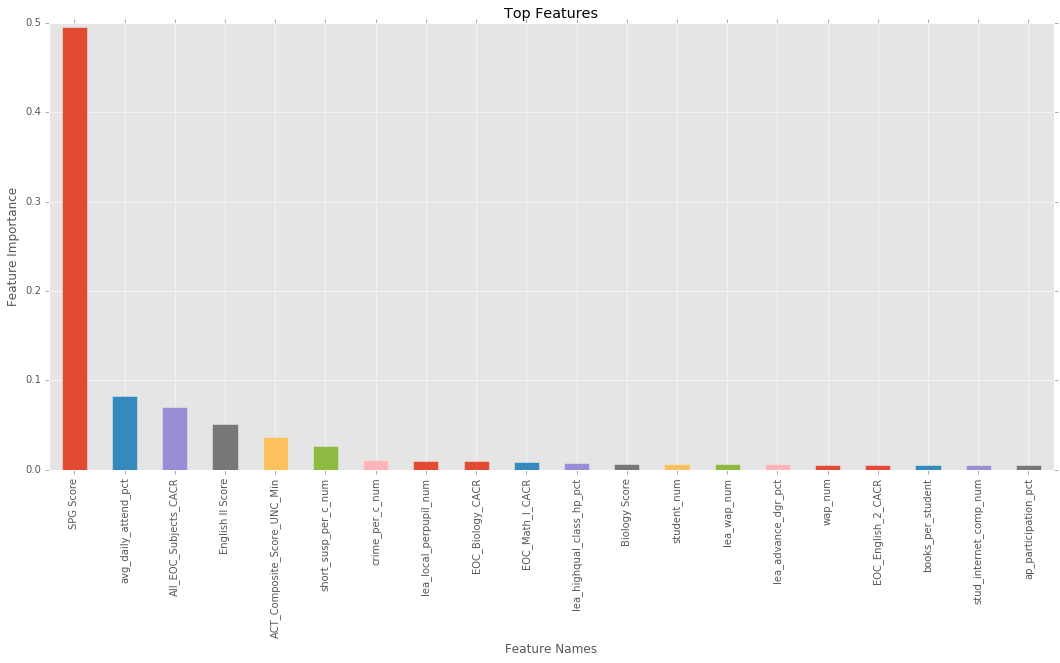

In [31]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(20)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(18,8))

ax.set_title("Top Features")
ax.set_ylabel("Feature Importance")
ax.set_xlabel("Feature Names")
plt.show()